In [ ]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from IPython.display import display, HTML, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# UNet

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)
        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)

class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))

    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x = self.token_embedding(tokens)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding

        return x


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=64,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=2,
        n_vocab=14,
        n_emb=128
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)
        self.embedding = nn.Embedding(n_vocab, n_emb)
        # self.pool = nn.AdaptiveAvgPool2d(n_emb)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t, text):
        time_emb = self.time_embeddings(t)
        text_emb = self.embedding(text)
        text_emb = text_emb.mean(dim=-2)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb + text_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h


# Diffusion

In [ ]:
class Diffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 32, 32),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta

        self.sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)

    def get_betas(self):
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )

def forward_diffusion(sd: Diffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps)
    sample  = mean + std_dev * eps

    return sample, eps

In [ ]:
def get(x: torch.Tensor, t: torch.Tensor):
  # print(x.get_device(), t.get_device())
  return x.gather(-1, t).reshape(-1, 1, 1, 1)

In [ ]:
def get_data(batch_size=32, num_workers=0, pin_memory=False, device="cpu"):
  transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32, 32),
                      interpolation=TF.InterpolationMode.BICUBIC,
                      antialias=True),
            TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1)
        ]
  )

  dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

  return dataloader

def inverse_transform(tensors):
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

100%|██████████| 170498071/170498071 [00:03<00:00, 49039051.14it/s]


Extracting data/cifar-10-python.tar.gz to data


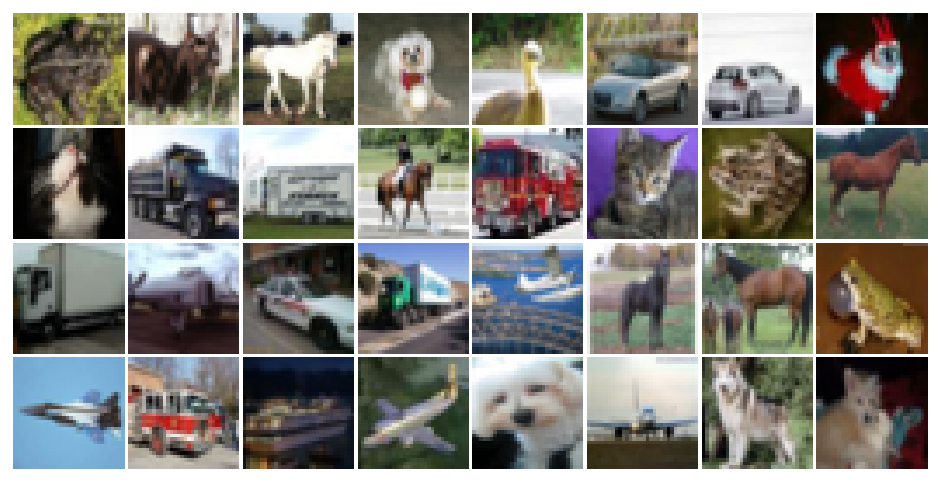

In [ ]:
plt.figure(figsize=(12, 6), facecolor='white')
loader = get_data()

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=8, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [ ]:
def make_dirs():
  os.makedirs('/content/drive/MyDrive/models', exist_ok=True)
  os.makedirs('/content/drive/MyDrive/images', exist_ok=True)
  # os.makedirs(os.path.join('models' + name), exists_ok=True)
  # os.makedirs(os.path.join('images' + name), exists_ok=True)
make_dirs()

Files already downloaded and verified
tensor([7, 7, 6, 8, 2, 3])


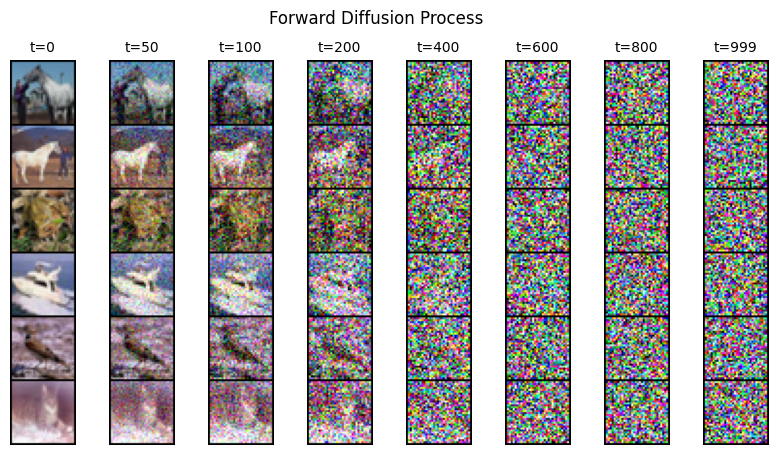

In [ ]:
d = Diffusion()

noisy_imgs = []
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]
loader = get_data(6)

for img, c in loader:
  print(c)
  for timestep in timesteps:
    timestep = torch.as_tensor([timestep] * img.shape[0], dtype=torch.long)

    img_with_noise, _ = forward_diffusion(d, img, timestep)
    img_with_noise = inverse_transform(img_with_noise) / 255.
    img_with_noise = make_grid(img_with_noise, nrow=1, padding=1)

    noisy_imgs.append(img_with_noise)
  break

_, ax = plt.subplots(1, len(noisy_imgs), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(timesteps, noisy_imgs)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=10)
    ax[i].axis("off")
    # ax[i].grid(False)

plt.suptitle("Forward Diffusion Process")
plt.axis("off")
plt.show()


# Training

In [ ]:
!pip install torchmetrics
from torchmetrics import MeanMetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 10.4 MB/s eta 0:00:00


In [ ]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
# class_names = np.arange(10)

class_names = {0: 'airplane',
               1: 'automobile',
               2: 'bird',
               3: 'cat',
               4: 'deer',
               5: 'dog',
               6: 'frog',
               7: 'horse',
               8: 'ship',
               9: 'truck'}

tokens = set()
tokens.update(*[tokenizer(f"photo of {name}") for _, name in class_names.items()])
tokens = list(tokens)
print(len(tokens))

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(tokens), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab(['a', 'photo', 'of', 'airplane', 'automobile', 'cat', 'dog', 'frog'])

12


[0, 10, 9, 1, 2, 4, 6, 7]

In [ ]:
# Training

def train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs=50, timesteps=1000):
  epoch_loss = MeanMetric()
  model.train()

  with tqdm(total=len(loader), dynamic_ncols=True) as tq:
    tq.set_description(f'Train :: Epoch: {epoch}/{epochs}')

    for x0, class_name in loader:
      tq.update(1)
      x0 = x0.to(device)

      text_inputs = []

      for name in class_name:
          text_inputs.append(vocab(f"photo of {class_names[name.item()]}".split()))
      text_inputs = torch.tensor(text_inputs).to(device)
      # print(text_inputs.shape)

      # text_inputs = torch.cat([clip.tokenize(f"a photo of a {name}") for name in class_name]).to(device)
      # text_inputs = get_text_representation([f"a photo of a {name}" for name in class_name], text_tokenizer, text_model, device).to(device).long()
      # text_inputs = torch.tensor([tokenizer(f"a photo of a {name}") for name in class_names])

      # print(len(text_inputs))

      # text_features = clip_model.encode_text(text_inputs)
      # print(text_features.shape)

      t = torch.randint(low=1, high=timesteps, size=(x0.shape[0],), device=device)
      xt, noise = forward_diffusion(d, x0, t)

      with amp.autocast():
        pred_noise = model(xt, t, text_inputs)
        loss = loss_func(noise, pred_noise)

      optimizer.zero_grad(set_to_none=True)
      scaler.scale(loss).backward()

      scaler.step(optimizer)
      scaler.update()

      loss_val = loss.detach().item()

      tq.set_postfix_str(s=f'Loss: {loss_val: .5f}')

      epoch_loss.update(loss_val)

    tq.set_postfix_str(s=f'Epoch loss: {epoch_loss.compute().item()}')

  return epoch_loss

In [ ]:
class_name = torch.randint(0, 10, (15,), device="cpu")
class_name

tensor([1, 4, 7, 6, 6, 6, 7, 7, 3, 4, 3, 6, 9, 9, 9])

In [ ]:
# Sampling
@torch.inference_mode()
def sampling(model, d, text_inputs, num_images=32, nrows=8, device="cuda"):
    x = torch.randn((num_images, *d.img_shape), device=device)
    # class_name = torch.ones(num_images, dtype=torch.long, device=device) * 5

    # class_name = torch.randint(0, 10, (num_images,), device=device)
    # text_inputs = torch.cat([clip.tokenize(f"a photo of a {name}") for name in class_name]).to(device)

    # print(text_inputs.shape)

    model.eval()

    for i in tqdm(reversed(range(1, d.num_diffusion_timesteps)), total=d.num_diffusion_timesteps-1, dynamic_ncols=False, desc="Sampling :: ", position=0):
        t = (torch.ones(num_images) * i).long().to(device)
        predicted_noise = model(x, t, text_inputs)

        one_by_sqrt_alpha_t = get(d.one_by_sqrt_alpha, t)
        sqrt_one_minus_alpha_hat_t = get(d.sqrt_one_minus_alpha_cumulative, t)
        sqrt_beta_t = get(d.sqrt_beta, t)
        beta_t = get(d.beta, t)

        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = one_by_sqrt_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_hat_t) * predicted_noise) + sqrt_beta_t * noise

    model.train()
    x = inverse_transform(x).type(torch.uint8)
    grid = torchvision.utils.make_grid(x, nrow=8, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    display(pil_image)

    return x


In [ ]:
model = UNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

loader = get_data(batch_size=128, num_workers=2, pin_memory=True, device=device)

d = Diffusion(device=device)
scaler = amp.GradScaler()
epochs = 65
num_images = 32

Files already downloaded and verified


In [ ]:
def save_images(images, path, **kwargs):
  grid = torchvision.utils.make_grid(images, **kwargs)
  ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
  im = Image.fromarray(ndarr)
  im.save(path)

In [ ]:
class_name = torch.randint(0, 10, (num_images,))
text_inputs = []
for name in class_name:
    # print(text_inputs)
    name = class_names[name.item()]
    text_inputs.append(vocab(f"a photo of a {name}".split()))
text_inputs = torch.tensor(text_inputs).to(device)
print(text_inputs)


tensor([[ 1, 11, 10,  1,  9],
        [ 1, 11, 10,  1,  3],
        [ 1, 11, 10,  1, 12],
        [ 1, 11, 10,  1,  4],
        [ 1, 11, 10,  1,  7],
        [ 1, 11, 10,  1, 13],
        [ 1, 11, 10,  1,  8],
        [ 1, 11, 10,  1,  6],
        [ 1, 11, 10,  1,  5],
        [ 1, 11, 10,  1,  2],
        [ 1, 11, 10,  1, 13],
        [ 1, 11, 10,  1,  4],
        [ 1, 11, 10,  1, 13],
        [ 1, 11, 10,  1,  3],
        [ 1, 11, 10,  1,  9],
        [ 1, 11, 10,  1,  9],
        [ 1, 11, 10,  1,  9],
        [ 1, 11, 10,  1,  7],
        [ 1, 11, 10,  1, 12],
        [ 1, 11, 10,  1,  8],
        [ 1, 11, 10,  1,  6],
        [ 1, 11, 10,  1, 12],
        [ 1, 11, 10,  1,  4],
        [ 1, 11, 10,  1, 12],
        [ 1, 11, 10,  1,  5],
        [ 1, 11, 10,  1, 13],
        [ 1, 11, 10,  1,  7],
        [ 1, 11, 10,  1,  8],
        [ 1, 11, 10,  1,  5],
        [ 1, 11, 10,  1,  2],
        [ 1, 11, 10,  1,  3],
        [ 1, 11, 10,  1,  6]], device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:44<00:00, 22.70it/s]


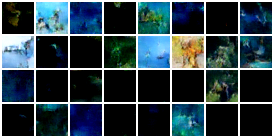

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.80it/s]


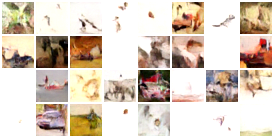

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.77it/s]


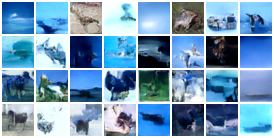

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.74it/s]


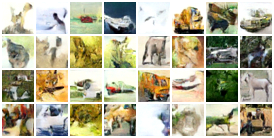

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.74it/s]


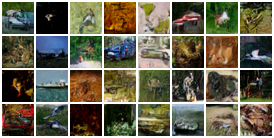

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.76it/s]


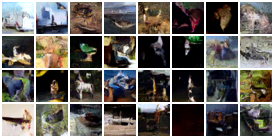

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.71it/s]


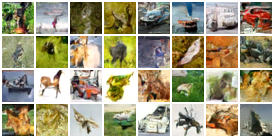

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.74it/s]


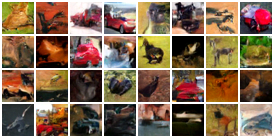

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.74it/s]


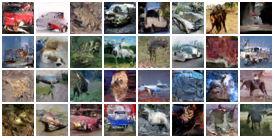

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.73it/s]


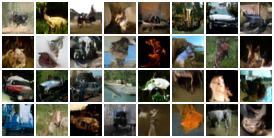

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.74it/s]


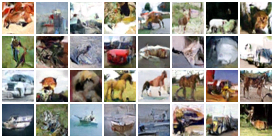

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.75it/s]


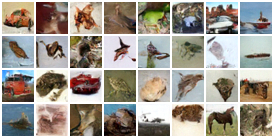

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.77it/s]


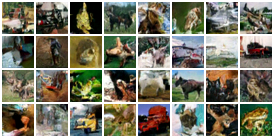

In [ ]:
for epoch in range(1, epochs + 1):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs)
  if epoch % 5 == 0:
    class_name = torch.randint(0, 10, (num_images,), device=device)

    text_inputs = []
    for name in class_name:
      name = class_names[name.item()]
      text_inputs.append(vocab(f"photo of {name}".split()))
    text_inputs = torch.tensor(text_inputs).to(device)

    res = sampling(model, d, text_inputs)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/content/drive/MyDrive/models", f"ckpt_text.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/content/drive/MyDrive/images", f"{epoch}_text.jpg"))



# Inference

In [ ]:
model = UNet()
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scaler = amp.GradScaler()

d = Diffusion(device=device)

loss_func = nn.MSELoss()
loader = get_data(batch_size=128, num_workers=2, pin_memory=True, device=device)

checkpoint = torch.load('/content/drive/MyDrive/models/ckpt_text.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['opt'])
scaler.load_state_dict(checkpoint['scaler'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.train()

Files already downloaded and verified


UNet(
  (time_embeddings): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (embedding): Embedding(14, 128)
  (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoder_blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (act_fn): SiLU()
      (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (dense_1): Linear(in_features=128, out_features=64, bias=True)
      (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (match_input): Identity()
      (attention): Identity()
    )
    (2): DownSample(
      (downsample): Conv2d(64, 64, kernel_size

Sampling :: 100%|██████████| 999/999 [01:16<00:00, 13.12it/s]


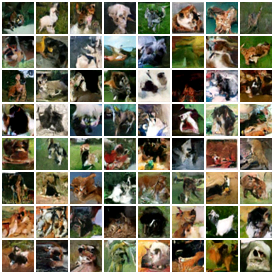

In [ ]:
text_inputs = []
# class_names = {0: 'airplane',
#                1: 'automobile',
#                2: 'bird',
#                3: 'cat',
#                4: 'deer',
#                5: 'dog',
#                6: 'frog',
#                7: 'horse',
#                8: 'ship',
#                9: 'truck'}
class_name = torch.ones(64, dtype=torch.long, device=device) * 1

for name in class_name:
  name = class_names[name.item()]
  text_inputs.append(vocab(f"photo of dog".split()))
text_inputs = torch.tensor(text_inputs).to(device)

res = sampling(model, d, text_inputs, num_images=64)
save_images(res, '/content/res5.jpg')

Sampling :: 100%|██████████| 999/999 [00:42<00:00, 23.27it/s]


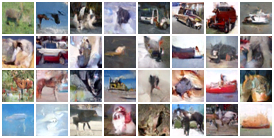

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 23.22it/s]


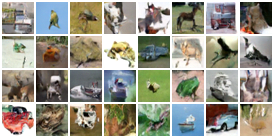

In [ ]:
for epoch in range(1, 11):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, 10)
  if epoch % 5 == 0:
    text_inputs = []
    # class_name = torch.ones(32, dtype=torch.long, device=device) * 7
    class_name = torch.randint(0, 10, (num_images,), device=device)


    for name in class_name:
      name = class_names[name.item()]
      text_inputs.append(vocab(f"photo of {name}".split()))
    text_inputs = torch.tensor(text_inputs).to(device)
    res = sampling(model, d, text_inputs)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/content/models", f"ckpt.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/content/", f"{epoch}+.jpg"))
